In [1]:
# Opcenito dobro za imati...
import numpy as np
import scipy as sp
import sklearn as skl
import cPickle

print "Verzije"
print "numpy - ",  np.__version__
print "scipy - " , sp.__version__
print "sklearn - ",  skl.__version__

Verzije
numpy -  1.12.1
scipy -  0.19.0
sklearn -  0.18.1


# Xception architecture  for Content based image retrieval
---

# Data 

In [2]:
# used data imports

import os
import pandas as pd
import voc_utils.voc_utils as voc
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2

print "Verzije"

print "pandas - " , pd.__version__
print "matplotlib - ",  matplotlib.__version__
print "PIL - ",  PIL.__version__
print "opencv - ",  cv2.__version__

# postavljanje roota voc utilsu
voc.root_dir='./data/VOCdevkit/VOC2007/'
voc.img_dir = os.path.join(voc.root_dir, 'JPEGImages/')
voc.ann_dir = os.path.join(voc.root_dir, 'Annotations')
voc.set_dir = os.path.join(voc.root_dir, 'ImageSets', 'Main')

Verzije
pandas -  0.19.2
matplotlib -  2.0.1
PIL -  4.1.1
opencv -  3.2.0


Xeption mreža trenirana je na Imagenet datasetu, pa sam uzeo neki drugi set za CBIR potrebe. Ispod se nalaze potrebni koraci kako bi skinuli Pascal VOC dataset. 

In [3]:
# Ne pitajte da li vam bas sve ovo treba, samo sam vam copypasta naredbe iz
# ovo repa --> https://github.com/smallcorgi/Faster-RCNN_TF
#
# !mkdir data&& cd data
# wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
# wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar
# tar xvf VOCtrainval_06-Nov-2007.tar
# tar xvf VOCtest_06-Nov-2007.tar
# tar xvf VOCdevkit_08-Jun-2007.tar
# cd ..

Ili napravite simbolički link ako ih već imate i tjt.

Također, da se ne gnjavimo sa kopanjem po tom datasetu i slično, našao sam ovaj repo koji sam skinuo i toplo preporučam.

https://github.com/mprat/pascal-voc-python

In [4]:
class_frame=pd.DataFrame(data={'razredi':voc.list_image_sets()})
class_frame

,razredi
0,aeroplane
1,bicycle
2,bird
3,boat
4,bottle
5,bus
6,car
7,cat
8,chair
9,cow


#### Tablice imaju class_id i true polja. Kako je u datotekama to zapisano, svaki razred ima svoj dataset sa slikama koje pripadaju toj klasi ali i onim koje ne pripadaju.
---
#### Akozelite pouzadni razred iz ovih tablica prvo uzmite sve gdje je true==1, a onda gledajte razred po zelji.

Od 20 klasa uzet ću njih 10 da mogu lakse raditi na svom laptopu.

In [5]:
class_count=2
target_classes=class_frame[:class_count]

In [6]:
def get_target_classes_df(target_classes,dataset='train'):
    full_df=None
    for id_,class_name in enumerate(target_classes.razredi.tolist()):
        df=voc.imgs_from_category(cat_name=class_name,dataset=dataset)
        df['class_id']=id_
        print id_,class_name, len(df)
        if full_df is None:
            full_df=df
        else:
            df.index+=len(full_df) #adjust indices
            full_df=pd.concat([full_df,df])
    return full_df

In [7]:
main_df=get_target_classes_df(target_classes,dataset='train')

0 aeroplane 2501
1 bicycle 2501


In [8]:
main_df[:10]

,filename,true,class_id
0,12,-1,0
1,17,-1,0
2,23,-1,0
3,26,-1,0
4,32,1,0
5,33,1,0
6,34,-1,0
7,35,-1,0
8,36,-1,0
9,42,-1,0


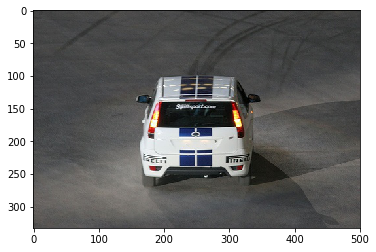

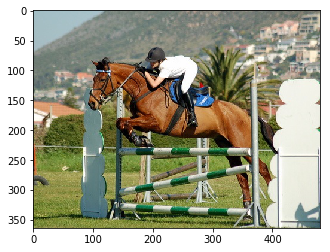

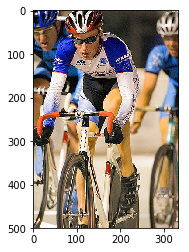

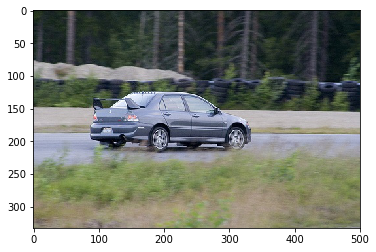

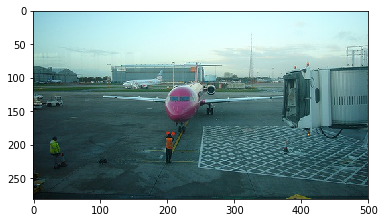

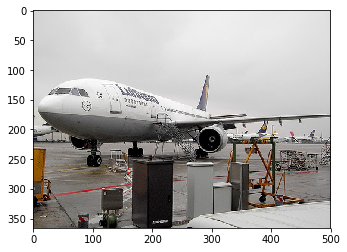

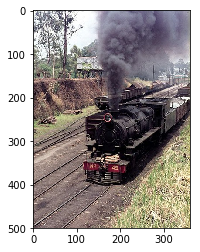

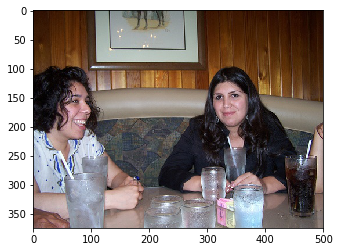

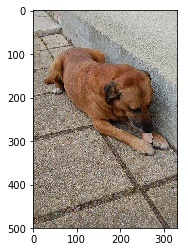

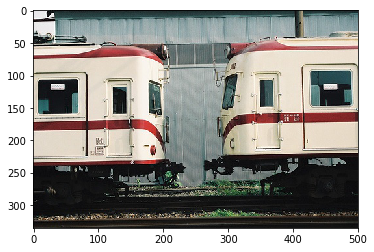

In [9]:
def proper_filename_format(x):
    return '%06d' %x
#Prikazi prvih 10 slikica
filenames=map(proper_filename_format,main_df.filename.tolist())[:10]

imgs=voc.load_imgs(filenames)

for img in imgs:
    plt.imshow(img)
    plt.show()

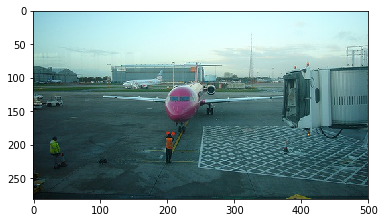

In [10]:
#Tko zeli provjeriti neku sliku samo neka izmjeni..
file_num=32
# ... i pokrene celiju.

def proper_filename_format(x):
    return '%06d' %x
img=voc.load_img(proper_filename_format(file_num))
plt.imshow(img);plt.show()

# Data preprocessing

Tu sam predvidio nekakav preprocessing. Za skinuti dataset samo cu provuci svaku sliku kroz `keras.kr.applications.xception.preprocess_input` i samo ih reshape-at na potrebne dimenzije. 

Za one koji nemaju keras tu sve pise:

https://github.com/fchollet/keras

Ostalo je sve pip install magic.

In [11]:
import keras as kr
import h5py 

print "Verzije"
print "keras - ",  kr.__version__
print "h5py - ", h5py.__version__ 

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

Using TensorFlow backend.


Verzije
keras -  2.0.4
h5py -  2.7.0


In [12]:
def preproc(x,shape=(299,299), net_preproc=kr.applications.xception.preprocess_input):
    if x.ndim == 4:
        return net_preproc(np.array([cv2.resize(img,shape)for img in x]))
    elif x.ndim == 3:
        return net_preproc(cv2.resize(x,shape))
    else:
        raise RuntimeError('Sta si to poslao u preproc l33k?!')

# Xception net

Za one zeljne znanja link na paper:
https://arxiv.org/pdf/1610.02357.pdf

Na žalost sve mi je palo u vodu. Stavio sam neke toy konvolucije da se uvjerim da nisam nesto zeznuo, ali tu nemam dovoljno memorije za vrtiti ove model. nvidia-smi mi kaze da imam 4GB memorije na grafickoj i tu [http://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/] sam iskopao da xception ima samo 91MB, ali da ga jebes, konzola mi javlja:

terminate called after throwing an instance of 'std::bad_alloc'
  what():  std::bad_alloc

@toni: Zao mi je master Toni, ali bojim se da ce na tebe pasti pokretanje ovih cudesa. 

Probat cu zavrsiti kod na slijepo nakon ove linije, fejskat podatke ili nesto, pa da znas da bi moglo biti bugz bunnyja. :P 

Btw, prvi link je dosta dobar, a ovdje mozete naci jos nesto o modelima:
https://keras.io/applications/

Preostali pre-trained modeli nalaze se ispod, a procedura koristenja je ista:

In [13]:
kr.applications.VGG16
kr.applications.VGG19
kr.applications.ResNet50
kr.applications.InceptionV3;

In [14]:
# Skidanje kroz model mi je bacalo cudan error.
# Ako i vi dobijete error preporucam iduce: 
# cd ~/.keras/models
# wget <link koji je model pokusao skinuti a bit ce ispisan u jupyteru>
#
# Opet pokrenete ovu celiju i radi.  
xception_model=kr.applications.xception.Xception(include_top=False, weights='imagenet')


In [15]:
from random import random
def net_mock(tensor):
    bs,_,_,_=tensor.shape
    return np.array([ np.random.normal(loc=5,scale=10,size=(10,10,10)) for _ in range(bs)])

In [16]:
from math import ceil
from base64 import b64decode,b64encode,decodestring

In [17]:
def load_preproc_imgs(img_filenames):
    '''
    Koristiti ovo ako slike idu u mrezu. Vraca 4d tensor dok njihova implementacija vraca listu 3d tensora razlicitih dimenzija.
    '''
    return np.array([preproc(voc.load_img(fname)) for fname in img_filenames])

def set_encoded64_numpy(df,column_name,vectors):
    '''
    Za spremanje feat. vektora u pandas najbolje korisiti ovo.
    '''
    df[column_name]=[ b64encode(v) for v in vectors]
    
def get_decoded64_numpy(df,column_name,dtype=np.float64):
    '''
    Za citanje svih feature vektora iz pandas df-a uzmite ovo. 
    '''
    return np.array([ np.frombuffer(decodestring(v),dtype=dtype) for v in df[column_name]])

Tu bi se trebala dogoditi carolija...

In [18]:
def get_features_from_model(df,model,batch_size=100, mock=False,debug_=True):
    
    batch_index=0
    total_batch=(int)(ceil(1.*len(df)/batch_size))

    df['feat']=None
    for _ in range(total_batch):
        # Batch df
        bdf=df[batch_index:batch_index+batch_size]
        batch_index+=batch_size
        # Batch img data
        batch=load_preproc_imgs(map(proper_filename_format,bdf.filename.tolist()))
        # Feat. extract
        if mock:
            features=net_mock(batch)
        else:
            features=model.predict(preproc(batch))
        # Add features
        N=features.shape[0]
        flat_feat=features.reshape((N,-1))
        set_encoded64_numpy(bdf,'feat',flat_feat)
    return df  

In [19]:
main_df=get_features_from_model(main_df,xception_model,batch_size=100, mock=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


U base64 formatu da se ne skrsi kad ga spremim u csv. 

In [20]:
main_df

,filename,true,class_id,feat
0,12,-1,0,aG3f7+lq4z/o7+Gm2VUtQIiu4H9LbwjAsg7NrJxfM0DsXI...
1,17,-1,0,Nuk50UVYHUC8JSOppXT1P7K9KvSKJUBA79xSoSxyMUDeZf...
2,23,-1,0,+koRHjP/JkD8fXqstdoVQPVUEMbU6ihAyiuE+GgUFEB8CX...
3,26,-1,0,6ogDWDpUNUB6c+v3NqIlQBItWS5YdS1ACETcm+g0F8BgTQ...
4,32,1,0,pHxzLiTLAMDdaRzc24cUQAwkHZv+lxTA/wyAjv3bK0CoCe...
5,33,1,0,h8fLd6P8IkDsHTYrqbMpQOikMRbJFgXAiAfRYjdX8L8e0w...
6,34,-1,0,eeFMg06cMkA8ZpdYJagvwGZNvsH2nAPAsBGGUMAN6L8znF...
7,35,-1,0,OXPtvkqMMECwEzsyTwbrP7DWaUMbpgrAzClggKTP/T/8KX...
8,36,-1,0,fjfUEJi+IMDBeslHFF0vQFUKrnpZVS9A5lrH9blSJsCMgB...
9,42,-1,0,1IHEHJRkBkC2mGb0ukQXQAmtbteKdglAtHVVXEMU+T/9zh...


In [21]:
features_csv_path='cache/feats.csv'

pd.DataFrame(data={'feat':main_df.feat}).to_csv(features_csv_path,index=False)


# Dimensionality reduction

Nista novo, samo copy pasta da mi bude tu...

In [22]:
import sklearn
from sklearn.decomposition import PCA
print "Verzije"
print "Sklearn - ",  sklearn.__version__
! ls
! mkdir model

Verzije
Sklearn -  0.18.1
AVSP.ipynb		  common.py	       model
cache			  data		       nmslib_template.ipynb
CBIR_Xception_test.ipynb  github_repositories  README.md
mkdir: cannot create directory ‘model’: File exists


In [23]:
reducer_path='model/PCA_1k_300.pkl'

In [24]:
features=get_decoded64_numpy(main_df,'feat')
reducer = PCA(n_components=300)
features_300=reducer.fit_transform(features)

In [25]:
set_encoded64_numpy(df=main_df,column_name='feat_red',vectors=features_300)

In [26]:
def perform_feat_red(df,reducer,src_col='feat',dest_col='feat_red'):
    feat=get_decoded64_numpy(df,src_col)
    feat_red=reducer.transform(feat)
    set_encoded64_numpy(df=df,column_name=dest_col,vectors=feat_red)
    return df

In [27]:
main_df

,filename,true,class_id,feat,feat_red
0,12,-1,0,aG3f7+lq4z/o7+Gm2VUtQIiu4H9LbwjAsg7NrJxfM0DsXI...,eSiBmdsuEsC6RSvLI1kzwEWFH4pb5yhAeinxNJ+qw79cNU...
1,17,-1,0,Nuk50UVYHUC8JSOppXT1P7K9KvSKJUBA79xSoSxyMUDeZf...,8hEqrzuNFMDuk7dk+g0QQFRv7YGeuOK/M9cg1quUO0CNLr...
2,23,-1,0,+koRHjP/JkD8fXqstdoVQPVUEMbU6ihAyiuE+GgUFEB8CX...,iZGWddaOOMD4TGr1ERQJQKmmcFDGcy3ANuacBf/UEkAqdS...
3,26,-1,0,6ogDWDpUNUB6c+v3NqIlQBItWS5YdS1ACETcm+g0F8BgTQ...,3CLDY9omPMDGx/3ZUtEWQDsTOlIzvhtAkNNjJjdnHcCIV5...
4,32,1,0,pHxzLiTLAMDdaRzc24cUQAwkHZv+lxTA/wyAjv3bK0CoCe...,F38bWGqmF0C+zoJQrSEvQAL2Uh1w2SZA7rVKniogAcDCbv...
5,33,1,0,h8fLd6P8IkDsHTYrqbMpQOikMRbJFgXAiAfRYjdX8L8e0w...,2eLF555nJkCzzVcBNLwQQLeaIx8ApQFAbr5KRopuA0DhDo...
6,34,-1,0,eeFMg06cMkA8ZpdYJagvwGZNvsH2nAPAsBGGUMAN6L8znF...,LhlxdnTFNcAV1V4l4YgeQC+/wQOpvQJAm1gqMJ26L8CSet...
7,35,-1,0,OXPtvkqMMECwEzsyTwbrP7DWaUMbpgrAzClggKTP/T/8KX...,9jKU8BYTMkAGyCxPUoMqwHSiKAANrvI/3csjPFL687/hVr...
8,36,-1,0,fjfUEJi+IMDBeslHFF0vQFUKrnpZVS9A5lrH9blSJsCMgB...,zvaKkhGvO0B7heS3m3YfQMjtFENQySjAIZdIbmpgMMBcV5...
9,42,-1,0,1IHEHJRkBkC2mGb0ukQXQAmtbteKdglAtHVVXEMU+T/9zh...,qNw5xzW7NsD6XAdv5AoZwA/cZYSMJRRATRnE4WWmM0DPnr...


In [28]:
features_reduced_csv_path='cache/feats_red.csv'
pd.DataFrame(data={'feat_red':main_df.feat_red}).to_csv(features_reduced_csv_path,index=False)

In [29]:
#save mode
with open(reducer_path, 'wb') as f:
    cPickle.dump(reducer, f)

# Indexing

Preuzeto iz nmslib_template uz manje promjene na citanje podataka jer su pdrugacije spremani podaci u ova dva slucaja. 

In [30]:
import nmslib

In [40]:
def read_data_fast_batch(fn, batch_size,colname='feat_red'):
    for df in pd.read_csv(fn, chunksize=batch_size):
        yield get_decoded64_numpy(df,colname).astype(np.float32)
        
def add_data_to_index(index,file_name,batch_size):
    offset=0
    for data_batch in read_data_fast_batch(file_name,batch_size):
        indices=np.arange(len(data_batch),dtype=np.int32)+offset
        nmslib.addDataPointBatch(index,indices,data_batch)
        offset+=data_batch.shape[0]
    return offset

def read_data_fast(fn, colname='feat_red'):
    df = pd.read_csv(fn)
    return get_decoded64_numpy(df,colname).astype(np.float32)

In [41]:
space_type = 'lp'
space_param = ['p=1']
method_name = 'small_world_rand'
index_param = ['NN=17', 'initIndexAttempts=3', 'indexThreadQty=4']
query_time_param = ['initSearchAttempts=3']
    
index_name  = method_name + '_sparse.index'
index = nmslib.init(space_type,
                        space_param,
                        method_name,
                        nmslib.DataType.DENSE_VECTOR,
                        nmslib.DistType.FLOAT)

last_offset=add_data_to_index(index,features_reduced_csv_path,100)

nmslib.createIndex(index, index_param)

nmslib.setQueryTimeParams(index,query_time_param)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


In [42]:
reducer_path='cache/index.pkl'
with open(reducer_path, 'wb') as f:
    cPickle.dump(index, f)

Ponovljen postupak citanja za nove podatke:

In [43]:
test_df=get_target_classes_df(target_classes,dataset='test')
test_df=get_features_from_model(test_df,xception_model,batch_size=100, mock=True)
test_df=perform_feat_red(test_df,reducer) #reducer je onaj gore nastimani PCA
test_df

0 aeroplane 4952
1 bicycle 4952


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,filename,true,class_id,feat,feat_red
0,1,-1,0,ass+MwgVF0BGfFN1tQUswDImxztAQSxATKiS56UcCcCyLh...,WDTuZ5bEEMBtI4TiEUzgP+sYnNdDSBzAuEQoTu/dA0CYRR...
1,2,-1,0,GMIWXoDlIUAQdO7j53r3P1LpFpqPjTVAeCow/nkU4r+juB...,F6QGlG3pM8BsBV6fnVABQHqkz3i9ZgTAao8x3e3HBUAZ+m...
2,3,-1,0,TFTl+o5KJsDEMxQkXCseQDhfQlpJgRVAieX9R/CmLEDI9d...,Z12Z60rCCMC0hYVWZvbVv9j797lNRwzA2amkauYJFUA3Td...
3,4,-1,0,rG/lN18NE8BzWr2GoEsSQP93kPzlSjRAtJ0v0sJ4DcDwg5...,JDaTO6cM9z8GETbmcZ8KwPT4oOm6/hNAkt36KJ2KGUDMfU...
4,6,-1,0,k1F1vWsAMUAsILSKClIkQNw0Nx4ddC1AtnzaNI21I8DWcT...,2krnLn6HIEAkS4HVV34jwG8EaFfFbw5Ac8TReHy3IUATzz...
5,8,-1,0,ZKO9++n1MEAGIHLtdIApQOA3j+5tBzpAcvgkxWtOJcDe04...,aa6rlwk7F8BR1MIM6Uk5QP9ea0puLyHAyvQVcZwzG8AKst...
6,10,-1,0,Rnh1po0AAMAw/qJsJOIYQOirG2zbJCjAvdZrIDURNkCggn...,mwQHUsU9JECgJklF0tf2v6YNPDlNkybAzoiDrDscEUC5dG...
7,11,-1,0,iknka0A0J0Dc71/hugsuQHi0v7Gn7CtAOKTApauhJEBWFI...,SLFYD34mJMCAAe3ujL7vvzjWhwqGTCBAvMpBB09j1T9ccb...
8,13,-1,0,Nky46n+vMkCSQQRPG9kAQFd2BwImShNAf9pm1+lhJEB00S...,pRPuNNESNEBa4wVTwAkIQJ9bTAauKzPAPDPWPfGBI0AVBC...
9,14,-1,0,uMRCvDdXC8CQxJQQ58ToP3A5OA6m29Q/qKJqQhIBA8BZg/...,9w6/KK5rAsDtTCaEVoAbQNjSLZ7Gh+c/mz+rb++FF0AwNg...


In [45]:
test_features_reduced_csv_path='cache/test_feats_red.csv'
pd.DataFrame(data={'feat_red':test_df.feat_red}).to_csv(test_features_reduced_csv_path,index=False)

In [46]:
k = 3
query = read_data_fast(test_features_reduced_csv_path)
num_threads = 10
res = nmslib.knnQueryBatch(index, num_threads, k, query)
res

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


array([[  49, 4936, 2871],
       [1513, 1936, 2530],
       [3967, 2717, 2405],
       ..., 
       [1835, 2679, 2939],
       [1717, 4188, 1423],
       [3965, 4874, 2453]], dtype=int32)

# Ovo je jako jako bitno da se napravi inace kod ostaje u memoriji.
---
# Pogotovo se odnosi na tonija jer sa puno podataka, ako budes radio indexe komp ce ti patiti. 

In [ ]:

nmslib.freeIndex(index)